# <a id='toc1_'></a>[this is check the model using no fucntion at all.](#toc0_)

In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = "C:/Users/rl1120/OneDrive - Imperial College London/SimDataSave/P3R13/"  #'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Target  = 'Revised_Poster/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [3]:
V_max = 4.2;        V_min = 2.5;
exp  = pybamm.Experiment(
    [ 
        (f"Discharge at 1 C until {V_min} V", 
        f"Charge at 3 C until {V_max} V",  # (5 minute period)
        f"Hold at {V_max} V until C/20"),] * 1 )  

In [4]:
# int - Dec=5e-10; single vs double 
Model_DFN_int  = pybamm.lithium_ion.DFN(options={
    "SEI":"interstitial-diffusion limited",            
    "SEI film resistance":"distributed",          
    "SEI porosity change":"true",   
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,}) 
Model_DD_int  = pybamm.lithium_ion.DFN(options={
    "SEI":"interstitial-diffusion limited",           
    "SEI film resistance":"distributed",          
    "SEI porosity change":"true",   
    "solvent diffusion": "double no consume wo refill",
    "electrolyte conductivity": "sol full"  ,}) 
Model_All_int =[ Model_DFN_int,   Model_DD_int ]
Str_model_int =[ 'Model_DFN_int', 'Model_DD_int' ]
# Para_All[0]: for single; Para_All[1]: for double
para=pybamm.ParameterValues("Li2023_ECdrag")
Para_All = []
for i in range(0,2):
    para=pybamm.ParameterValues("Li2023_ECdrag")
    para.update({"EC initial concentration in electrolyte [mol.m-3]":3500})
    para.update({"Typical EC concentration [mol.m-3]":3500})
    para.update({'EC diffusivity in SEI [m2.s-1]':5e-20})
    para.update({"EC diffusivity in electrolyte [m2.s-1]":EC_diffusivity_5E_10})
    para.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':3e-19})
    para.update({"EC Lithium ion cross diffusivity [m2.s-1]":Cross_diffusivity_1p5E_10})
    para.update({"Cation transference number":electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con})
    para.update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con})
    para.update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con})
    Para_All.append(para)
Para_All[0].update({"Measured dLJP_dce":dLJP_One_Specie_dce_Jung2023})
# check 
print(Para_All[0]["Measured dLJP_dce"])
print(Para_All[1]["Measured dLJP_dce"])
Sol_all_int =[];
for model,para in zip(Model_All_int,Para_All):
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para["Electrolyte diffusivity [m2.s-1]"]
    D_EC= para["EC diffusivity in electrolyte [m2.s-1]"]
    sigma_e = para["Electrolyte conductivity [S.m-1]"]
    Xi = para["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["EC diffusivity in electrolyte [m2.s-1]"] = D_EC(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    t_0plus = para["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)

    var_pts = {
        "x_n": 10,  # negative electrode
        "x_s": 5,  # separator 
        "x_p": 10,  # positive electrode
        "r_n": 30,  # negative particle
        "r_p": 20,  # positive particle
    }

    sim    = pybamm.Simulation(
        model, experiment = exp,
        parameter_values = para,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,)       
    Sol_all_int.append(sim.solve())

Confirm: using interstitial-diffusion limited
Confirm: using interstitial-diffusion limited
<function dLJP_One_Specie_dce_Jung2023 at 0x0000027A369503A0>
<function dLJP_Two_Species_dce_Jung2023 at 0x0000027A36AD0CA0>


In [5]:
# int - Dec=3e-10; single vs double 
Model_DFN_int_lowDx  = pybamm.lithium_ion.DFN(options={
    "SEI":"interstitial-diffusion limited",             
    "SEI film resistance":"distributed",          
    "SEI porosity change":"true",   
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,}) 
Model_DD_int_lowDx  = pybamm.lithium_ion.DFN(options={
    "SEI":"interstitial-diffusion limited",             
    "SEI film resistance":"distributed",          
    "SEI porosity change":"true",   
    "solvent diffusion": "double no consume wo refill",
    "electrolyte conductivity": "sol full"  ,}) 
Model_All_int_lowDx =[ Model_DFN_int_lowDx ,   Model_DD_int_lowDx ]
Str_model_int_lowDx =[ 'Model_DFN_int_lowDx', 'Model_DD_int_lowDx' ]
# Para_All[0]: for single; Para_All[1]: for double
para=pybamm.ParameterValues("Li2023_ECdrag")
Para_All = []
for i in range(0,2):
    para=pybamm.ParameterValues("Li2023_ECdrag")
    para.update({"EC initial concentration in electrolyte [mol.m-3]":3500})
    para.update({"Typical EC concentration [mol.m-3]":3500})
    para.update({'EC diffusivity in SEI [m2.s-1]':5e-20})
    para.update({"EC diffusivity in electrolyte [m2.s-1]":EC_diffusivity_5E_10})
    para.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':3e-19})
    para.update({"EC Lithium ion cross diffusivity [m2.s-1]":Cross_diffusivity_1p5E_12})
    para.update({"Cation transference number":electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con})
    para.update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con})
    para.update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con})
    Para_All.append(para)
Para_All[0].update({"Measured dLJP_dce":dLJP_One_Specie_dce_Jung2023})
# check 
print(Para_All[0]["Measured dLJP_dce"])
print(Para_All[1]["Measured dLJP_dce"])
Sol_all_int_lowDx =[];
for model,para in zip(Model_All_int_lowDx,Para_All):
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para["Electrolyte diffusivity [m2.s-1]"]
    D_EC= para["EC diffusivity in electrolyte [m2.s-1]"]
    sigma_e = para["Electrolyte conductivity [S.m-1]"]
    Xi = para["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["EC diffusivity in electrolyte [m2.s-1]"] = D_EC(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    t_0plus = para["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)
    var_pts = {
        "x_n": 10,  # negative electrode
        "x_s": 5,  # separator 
        "x_p": 10,  # positive electrode
        "r_n": 30,  # negative particle
        "r_p": 20,  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = exp,
        parameter_values = para,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,)       
    Sol_all_int_lowDx.append(sim.solve())

Confirm: using interstitial-diffusion limited
Confirm: using interstitial-diffusion limited
<function dLJP_One_Specie_dce_Jung2023 at 0x0000027A369503A0>
<function dLJP_Two_Species_dce_Jung2023 at 0x0000027A36AD0CA0>


In [8]:
# all solutions to compare:
# Sol_all_sol          Str_model_sol
# Sol_all_sol_lowDx   Str_model_sol_lowDx
# Sol_all_int_lowDx;  Str_model_int_lowDx
# Sol_all_int          Str_model_int
model.variables.search("SEI")

EC source term (SEI)
Inner SEI concentration [mol.m-3]
Inner SEI interfacial current density
Inner SEI interfacial current density [A.m-2]
Inner SEI on cracks concentration [mol.m-3]
Inner SEI on cracks interfacial current density
Inner SEI on cracks interfacial current density [A.m-2]
Inner SEI on cracks thickness
Inner SEI on cracks thickness [m]
Inner SEI thickness
Inner SEI thickness [m]
Loss of capacity to SEI [A.h]
Loss of capacity to SEI on cracks [A.h]
Loss of lithium to SEI [mol]
Loss of lithium to SEI on cracks [mol]
Negative electrode SEI interfacial current density
Negative electrode SEI interfacial current density [A.m-2]
Negative electrode SEI on cracks interfacial current density
Negative electrode SEI on cracks interfacial current density [A.m-2]
Negative electrode SEI on cracks volumetric interfacial current density
Negative electrode SEI on cracks volumetric interfacial current density [A.m-3]
Negative electrode SEI volumetric interfacial current density
Negative elec

[0.0, 59.999999999999545, 120.0, 179.99999999999955, 240.0, 299.99999999999955, 337.05139725006256]
[0.0, 59.999999999999545, 120.0, 179.99999999999955, 240.0, 299.99999999999955, 337.051397250048]
[0.0, 59.999999999999545, 120.0, 179.99999999999955, 240.0, 299.99999999999955, 330.1874586598278]
[0.0, 59.999999999999545, 120.0, 179.99999999999955, 240.0, 299.99999999999955, 338.6544171550581]
[5, 5, 5, 5] 299.99999999999955


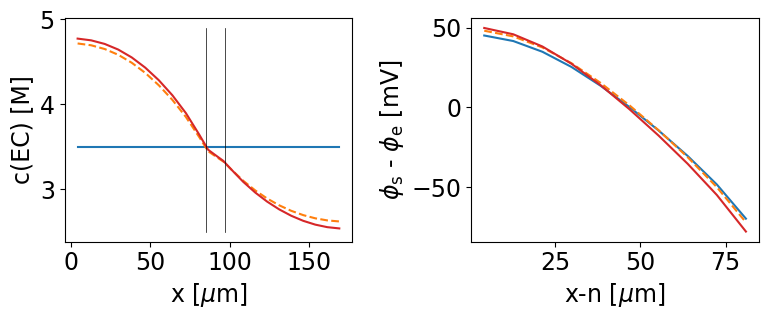

In [16]:
# plot only things happen during 3C CC charge
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
LS = ['-','--','-','--',];MS=['s','^','h']; ms = 8
Sol_plt = [Sol_all_int[0],Sol_all_int_lowDx[0],Sol_all_int[1],Sol_all_int_lowDx[1],]
t_int_all = []; Index_t_select = []; 
fig, axs = plt.subplots(1,2, figsize=(8,3.5),tight_layout=True)
for i in range(4):
    sol = Sol_plt[i]
    t_int_all.append((
        sol.cycles[0].steps[1]['Time [s]'].entries
        - sol.cycles[0].steps[1]['Time [s]'].entries[0]).tolist())
    print(t_int_all[-1])
t_select = min(t_int_all[0][-2],t_int_all[1][-2],t_int_all[2][-2],t_int_all[3][-2])
for i in range(4):
    Index_t_select.append(FindClose(t_int_all[i],t_select))
print(Index_t_select,t_select)
for i in [0,3,2]: # range(4):
    sol = Sol_plt[i]
    x =   sol.cycles[0].steps[1]["x [m]"].entries[:,0]
    x_n =   sol.cycles[0].steps[1]["x_n [m]"].entries[:,0]
    c_EC =   sol.cycles[0].steps[1]["EC concentration [mol.m-3]"].entries[:,Index_t_select[i]]
    j_SEI =   sol.cycles[0].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,Index_t_select[i]]
    eta_SEI =   sol.cycles[0].steps[1]["Negative electrode surface potential difference [V]"].entries[:,Index_t_select[i]]
   
    axs[0].plot(x*1e6, c_EC/1e3, color=Colors[i],linestyle=LS[i],) # label=r"Single-High $D_\times$" 
    
    axs[1].plot(x_n*1e6, eta_SEI*1e3, color=Colors[i],linestyle=LS[i]) 
    #axs[2].plot(x_n*1e6, abs(j_SEI)*1e3, color=Colors[i],linestyle=LS[i]) 

    #axs[i].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs})
    axs[0].set_xlabel(r"x [$\mu$m]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[1].set_xlabel(r"x-n [$\mu$m]",   fontdict={'family':'DejaVu Sans','size':fs})
    #axs[2].set_xlabel(r"x-n [$\mu$m]",   fontdict={'family':'DejaVu Sans','size':fs})
    axs[0].ticklabel_format( 
        axis='x', style='sci',
        scilimits=[-1e3,1e3], useOffset=None, 
        useLocale=None, useMathText=None)
axs[0].set_ylabel("c(EC) [M]")
#axs[0].set_ylim([3.1,4.1])
#axs[2].set_ylim([-2.5,75])
#axs[2].set_ylabel("j$_{SEI}$ [mA/m$^{-2}$]")
axs[1].set_ylabel("$\phi$$_\mathrm{s}$ - $\phi$$_\mathrm{e}$ [mV]")
Y_0p = np.arange(2.5,5,0.1)
axs[0].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
axs[0].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
# 85.2 ; 12; 75.6
plt.savefig(BasicPath + Target+"3C_c_EC_j_SEI.png", dpi=800)

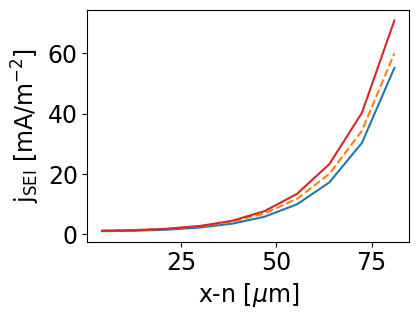

In [13]:
# plot only things happen during 3C CC charge
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)

fig, axs = plt.subplots(figsize=(4.5,3.5),tight_layout=True)

for i in [0,3,2]:
    sol = Sol_plt[i]
    x =   sol.cycles[0].steps[1]["x [m]"].entries[:,0]
    x_n =   sol.cycles[0].steps[1]["x_n [m]"].entries[:,0]
    c_EC =   sol.cycles[0].steps[1]["EC concentration [mol.m-3]"].entries[:,Index_t_select[i]]
    j_SEI =   sol.cycles[0].steps[1]["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,Index_t_select[i]]
    eta_SEI =   sol.cycles[0].steps[1]["SEI film overpotential [V]"].entries[:,Index_t_select[i]]
    axs.plot(x_n*1e6, abs(j_SEI)*1e3, color=Colors[i],linestyle=LS[i]) 

    axs.set_xlabel(r"x-n [$\mu$m]",   fontdict={'family':'DejaVu Sans','size':fs})
    

axs.set_ylabel("j$_\mathrm{SEI}$ [mA/m$^{-2}$]")

plt.savefig(BasicPath + Target+"3C_only_j_SEI.png", dpi=800)